In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.templates.default = 'plotly_white'
pio.renderers.default = 'png'
px.defaults.width = 1500
px.defaults.height = 500

# Plot Functions

In [2]:
def plot_kmeans(centers, labels):
    
    fig1 = px.imshow(centers.round(2), color_continuous_scale='Blues', text_auto=True, aspect='auto')
    fig1.update_layout(
        xaxis_title='', yaxis_title='Cluster Centers'
    )
    
    fig2 = px.scatter(labels)
    fig2.update_layout(
        showlegend=False, xaxis_title='Date', yaxis_title='Cluster Label'
    )
    fig2.update_yaxes(categoryorder='array', categoryarray=centers.index[::-1])
    
    return fig1, fig2

# Data - Setup

In [3]:
ll = pd.read_csv('../data/data1.csv')
ll = ll.set_index('Date')

ll = -100*(np.log(ll)-np.log(ll.shift(1)))
ll = ll.iloc[1:]

ll = ll.rename_axis('Loss', axis=1)
ll.columns = [x[4:] for x in ll.columns]

In [4]:
# Standardize marginals
z = ll.apply(lambda x: 1/(1-x.rank()/(len(x)+1)), axis=0)

# Angular measure
r = z.apply(lambda x: np.linalg.norm(x,2), axis=1)
w = z.div(r, axis=0)

In [5]:
# Threshold
r0 = np.quantile(r,0.95)

# K-Means Clustering
This should not be done since theoretically the mean does not exist for Frechet 1 distributions which means kmeans can't be used.
## Optimal k

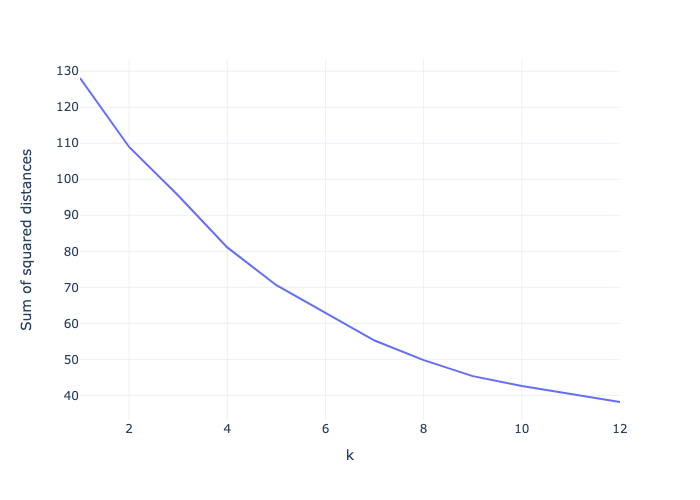

In [6]:
sum_of_squared_distances = []
K = range(1,13)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(w[r>r0])
    sum_of_squared_distances.append(km.inertia_)
    
px.line(x=K, y=sum_of_squared_distances).update_layout(xaxis_title='k', yaxis_title='Sum of squared distances', width=700)

## n_clusters=7

In [7]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(w[r>r0])
centers = pd.DataFrame(kmeans.cluster_centers_, index=['C'+str(i) for i in range(1,8)], columns=ll.columns)
labels = pd.Series(kmeans.labels_+1, index=w[r>r0].index).apply(lambda x: 'C'+str(x))

fig1, fig2 = plot_kmeans(centers,labels)

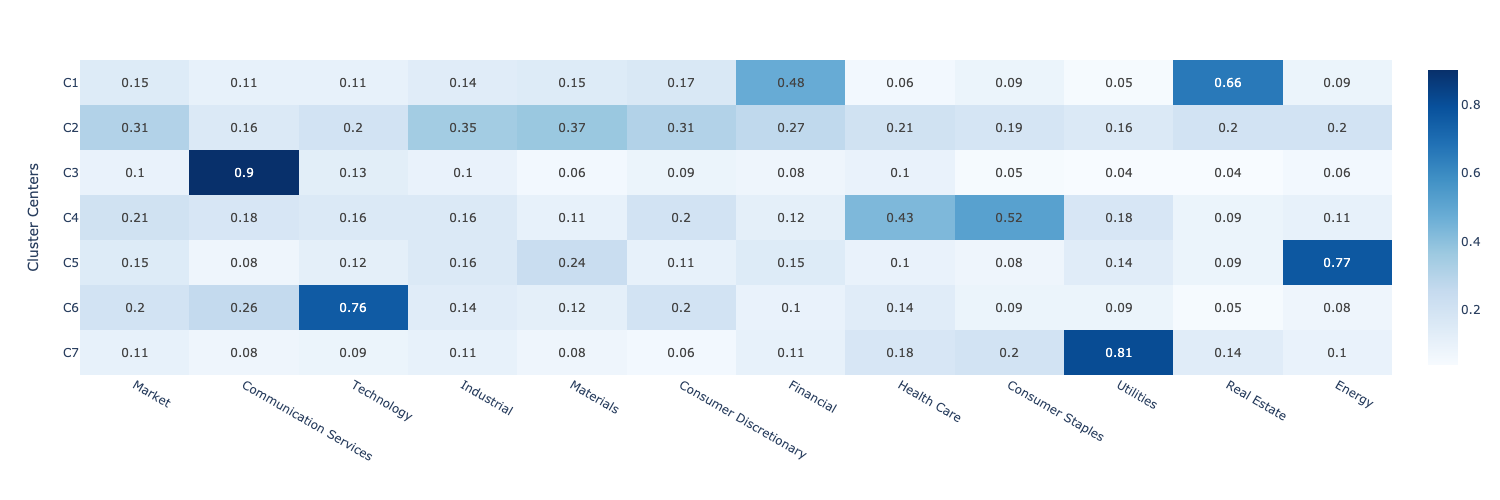

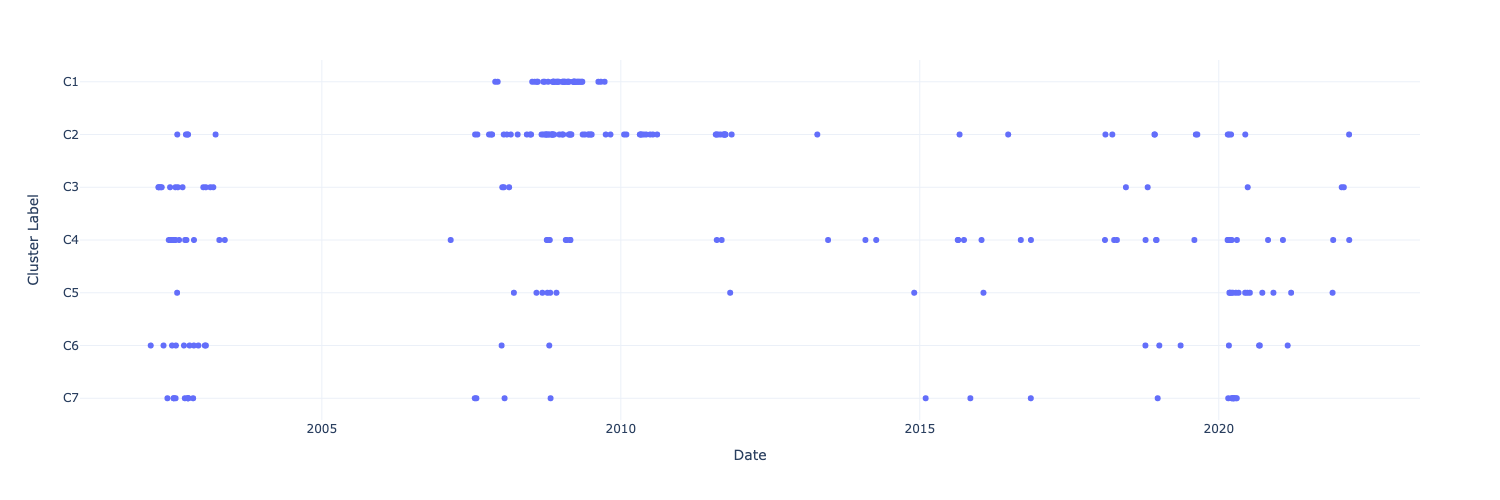

In [8]:
#fig1.write_image('../figures/x.jpeg', scale=2)
#fig2.write_image('../figures/x.jpeg', scale=2)
fig1.show()
fig2.show()

## n_clusters=7, start=chi_network

In [9]:
centers_init = np.array([
    [0.2,0,0,0.2,0.2,0.2,0.2,0,0,0,0,0],
    [0,0,0,0,0,0,0,0.5,0.5,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,0,0,1]
])

kmeans = KMeans(n_clusters=7, init=centers_init, n_init=1, random_state=0).fit(w[r>r0])
centers = pd.DataFrame(kmeans.cluster_centers_, index=['C'+str(i) for i in range(1,8)], columns=ll.columns)
labels = pd.Series(kmeans.labels_+1, index=w[r>r0].index).apply(lambda x: 'C'+str(x))

fig1, fig2 = plot_kmeans(centers,labels)

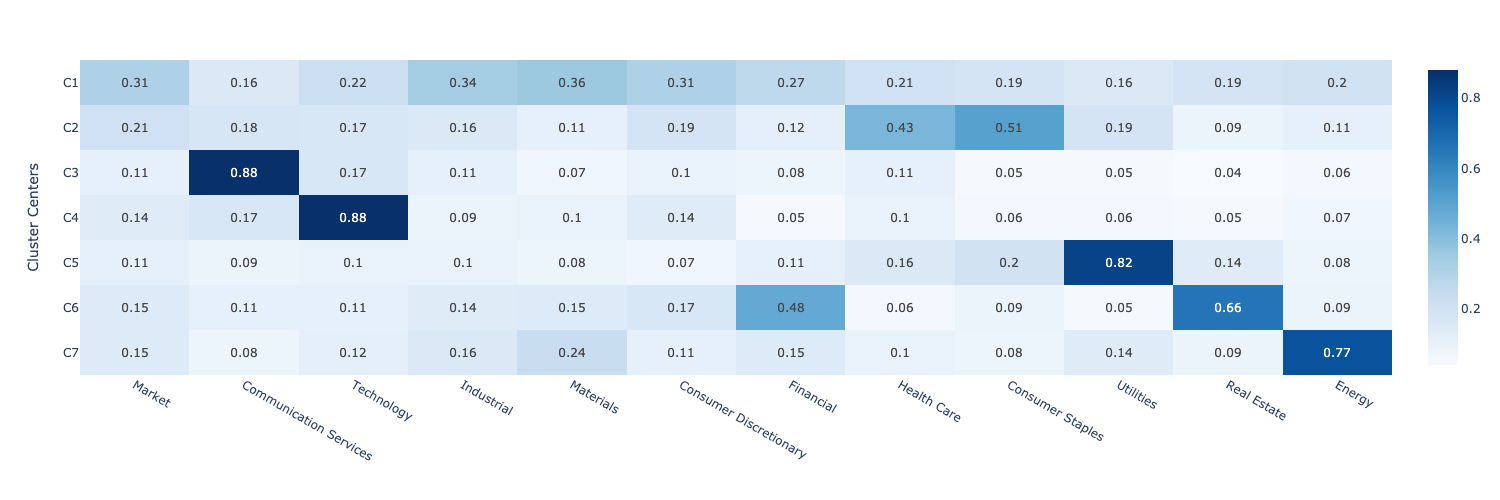

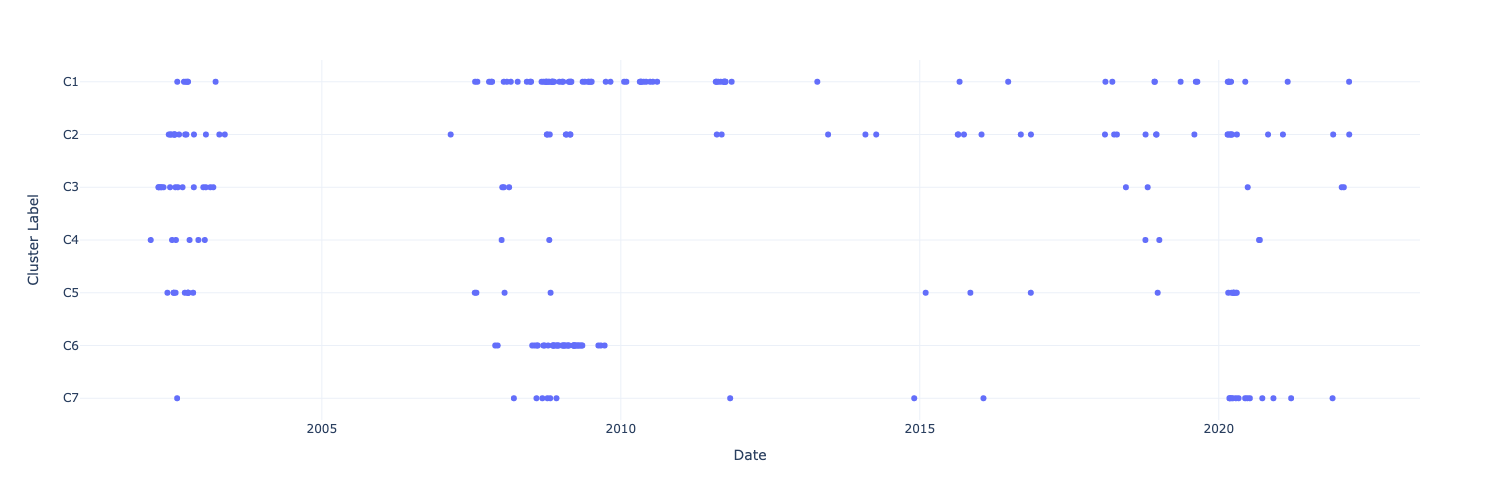

In [10]:
#fig1.write_image('../figures/x.jpeg', scale=2)
#fig2.write_image('../figures/x.jpeg', scale=2)
fig1.show()
fig2.show()

# Spherical K-Means

In [11]:
def R_kmeans(k):
    
    centers = pd.read_csv('../data/skmeans'+str(k)+'_centers.csv').iloc[:,1:]
    centers.columns = ll.columns[1:]
    centers.index = ['C'+str(i) for i in range(1,k+1)]

    labels = pd.read_csv('../data/skmeans'+str(k)+'_labels.csv').iloc[:,1]
    labels.index = w[r>r0].index
    labels = labels.apply(lambda x: 'C'+str(x))
    
    return plot_kmeans(centers,labels)

## n_clusters=2,...,7

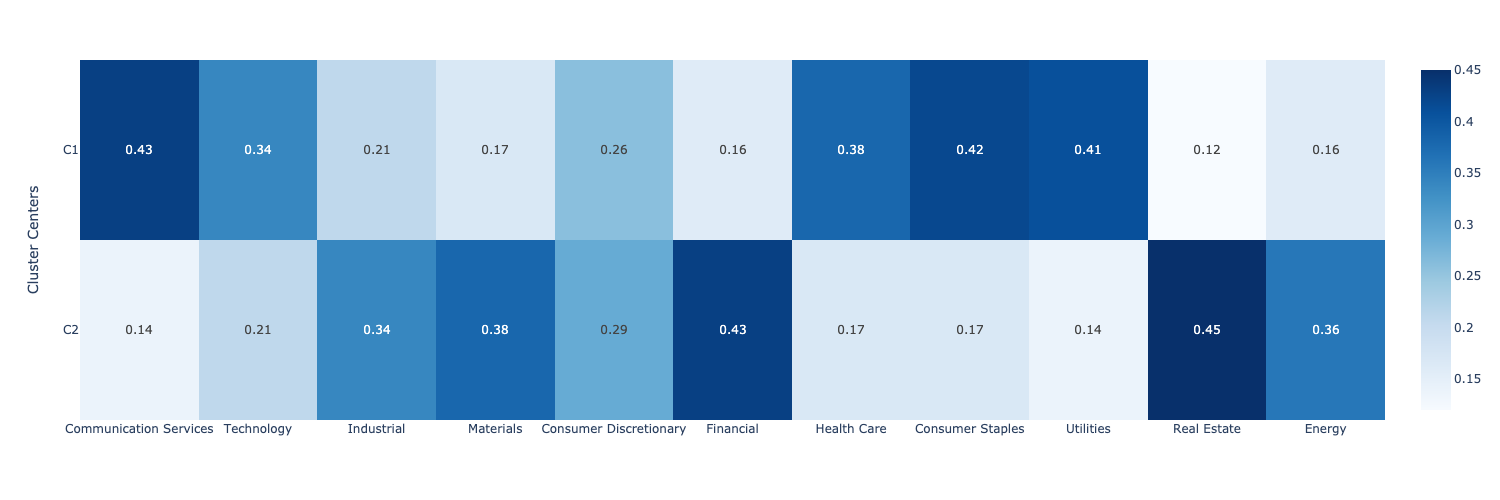

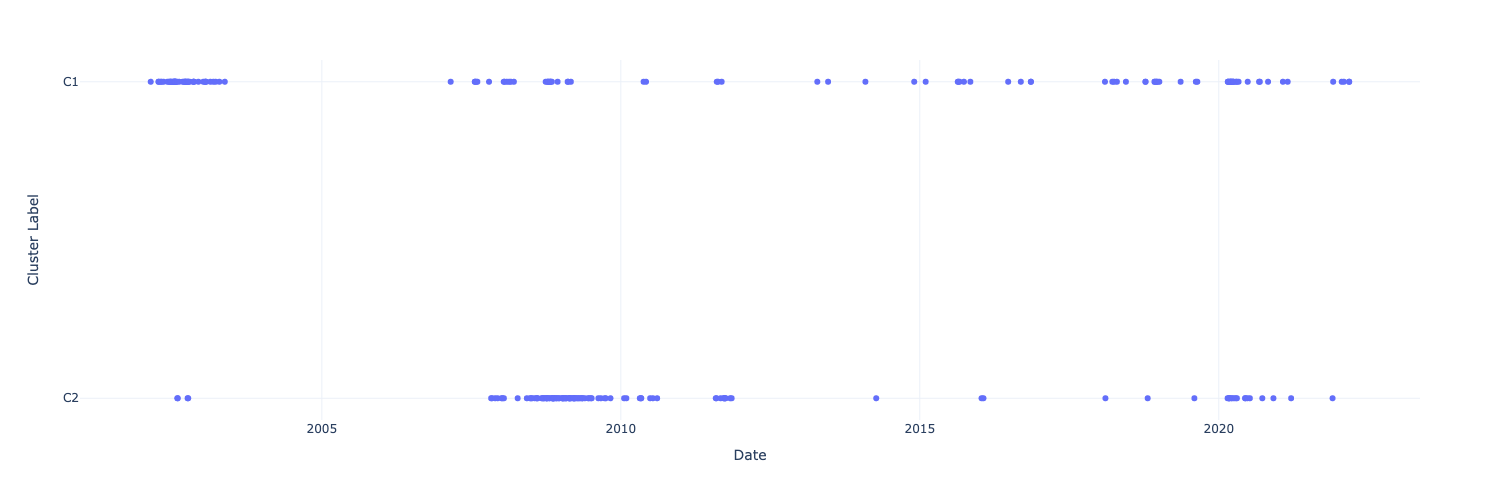

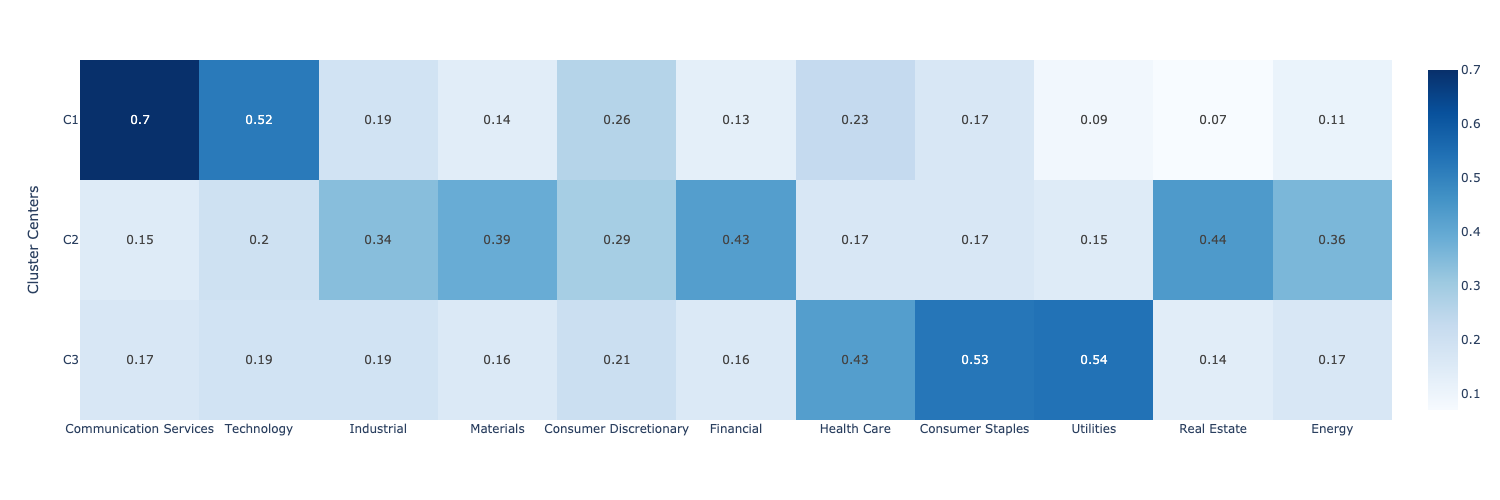

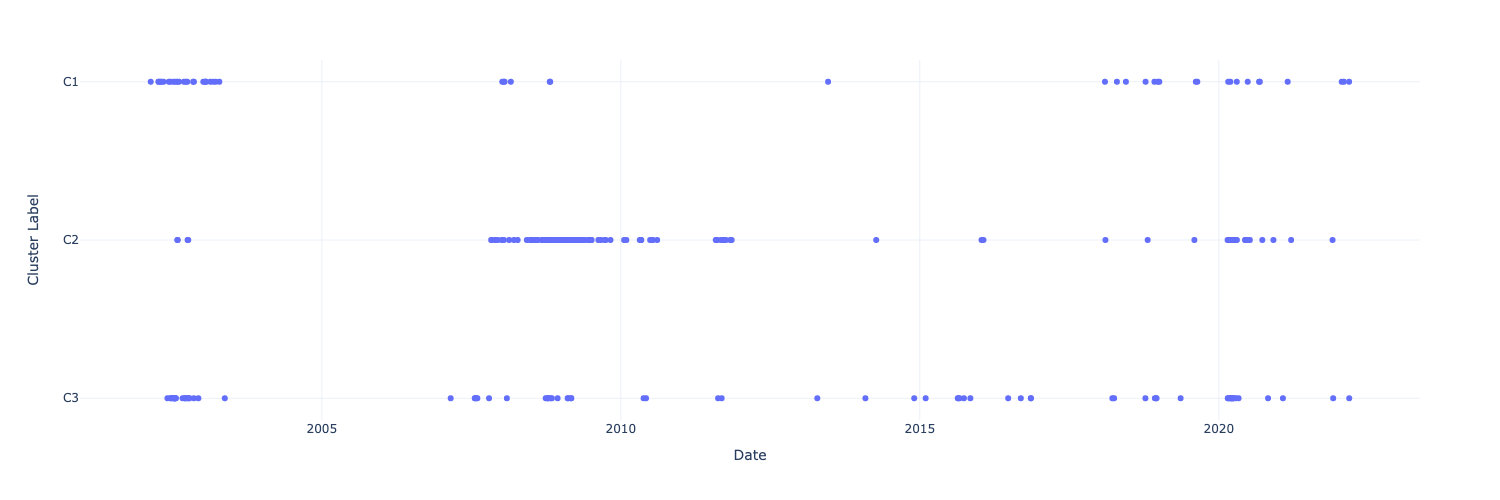

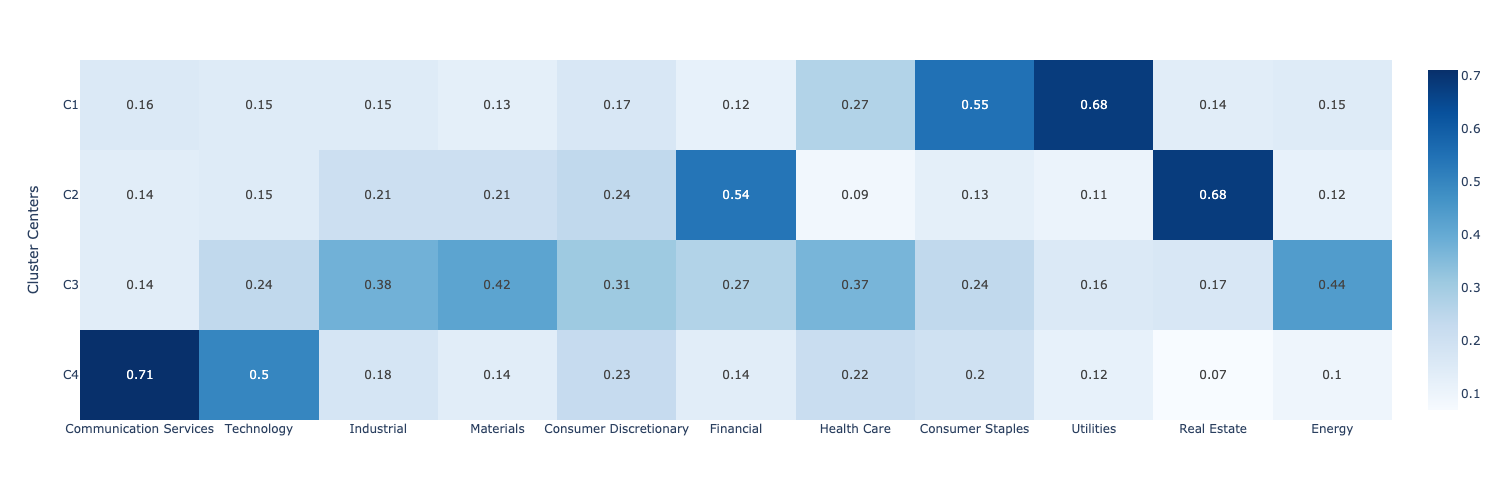

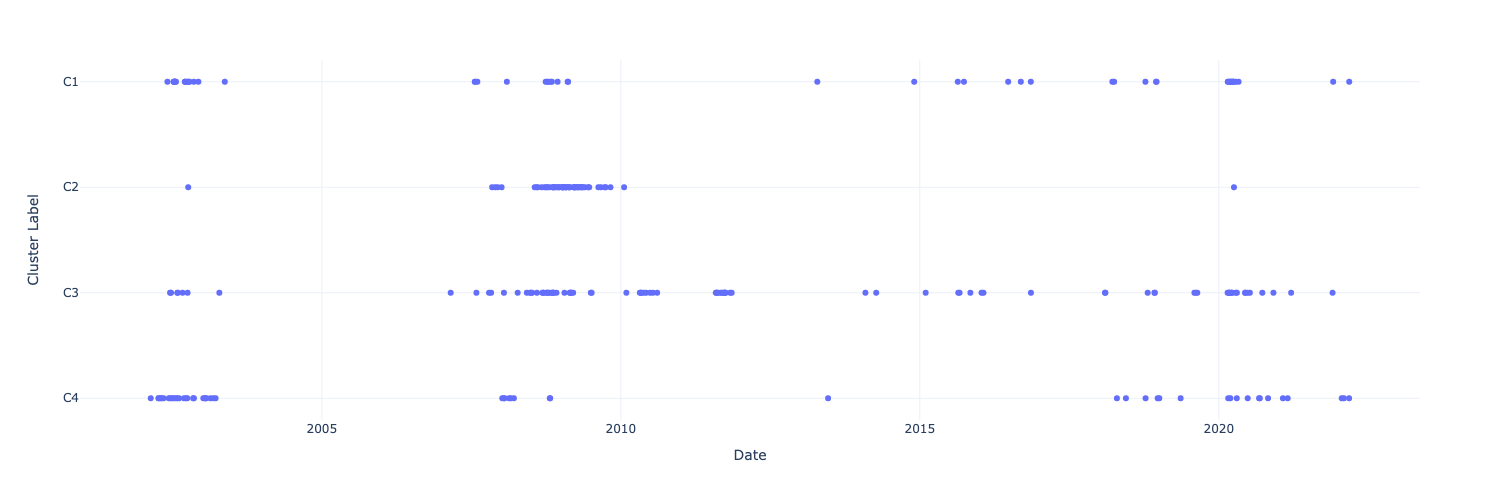

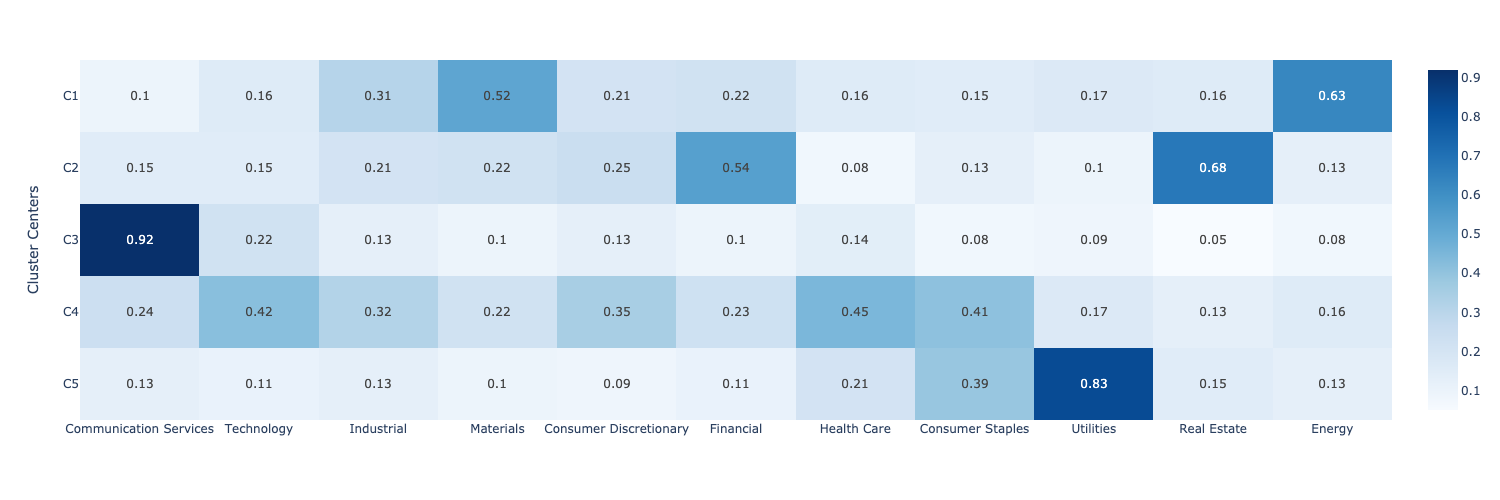

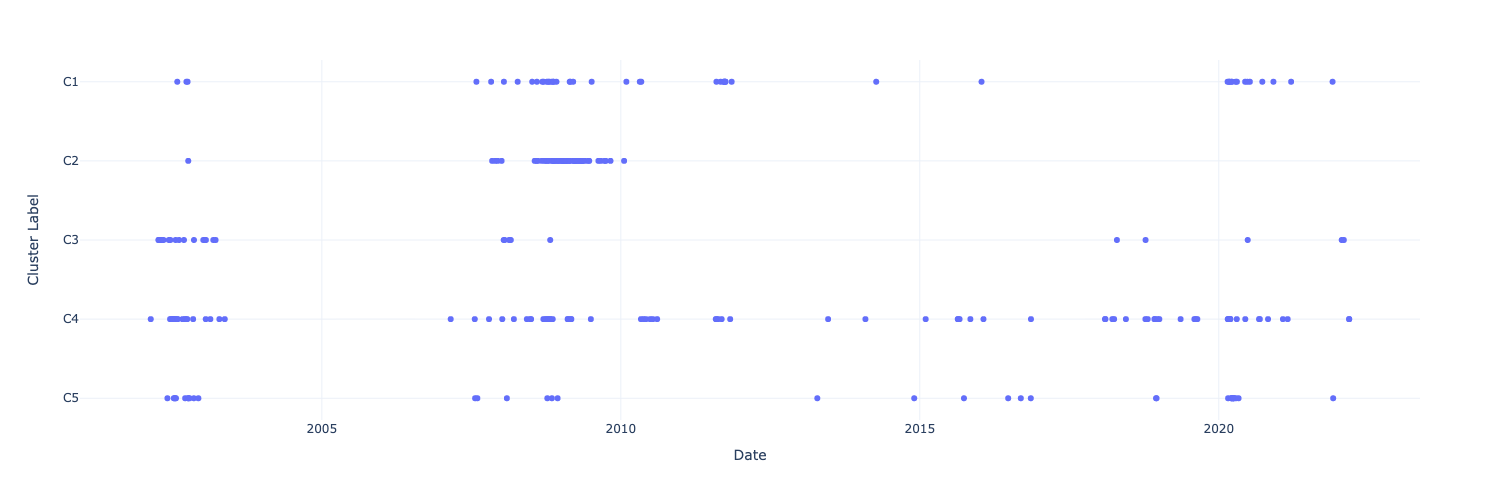

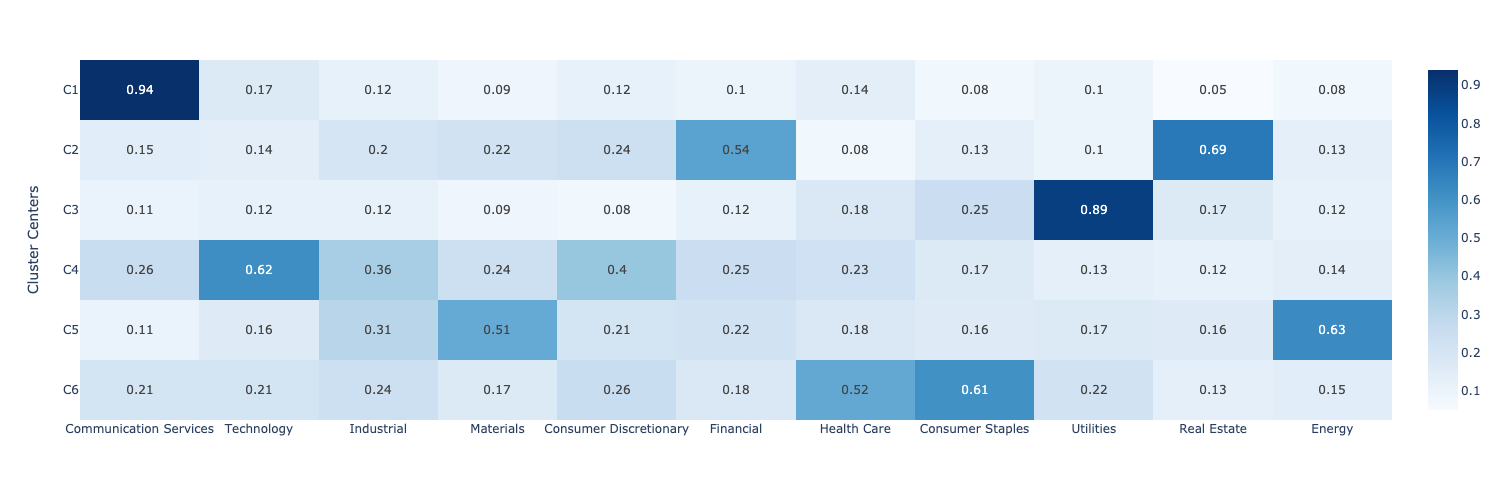

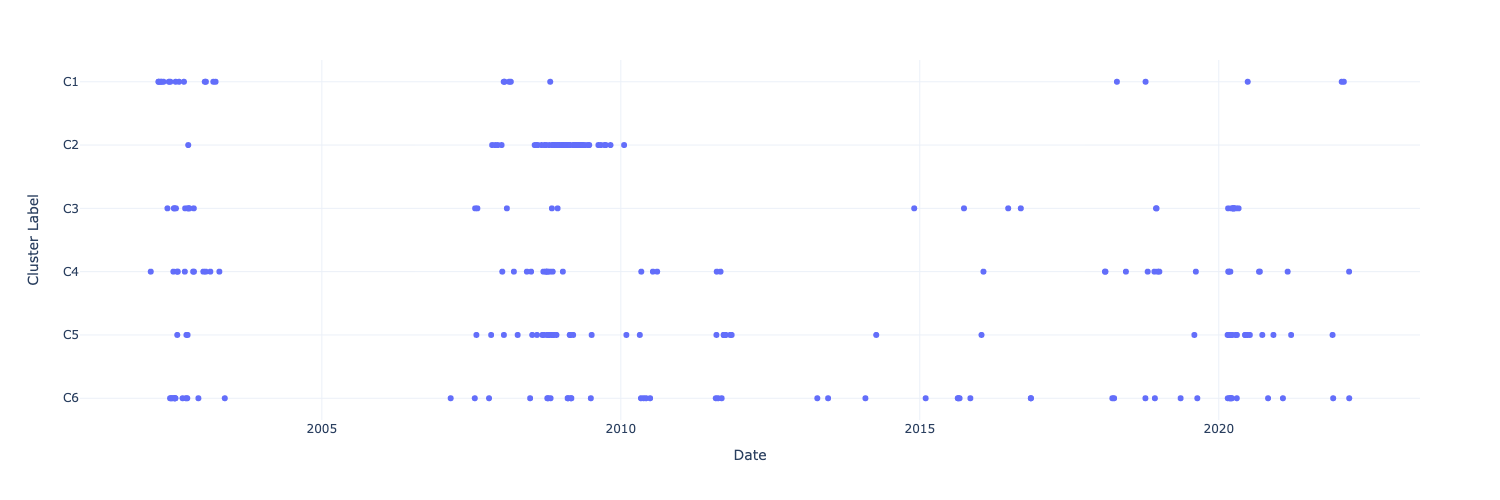

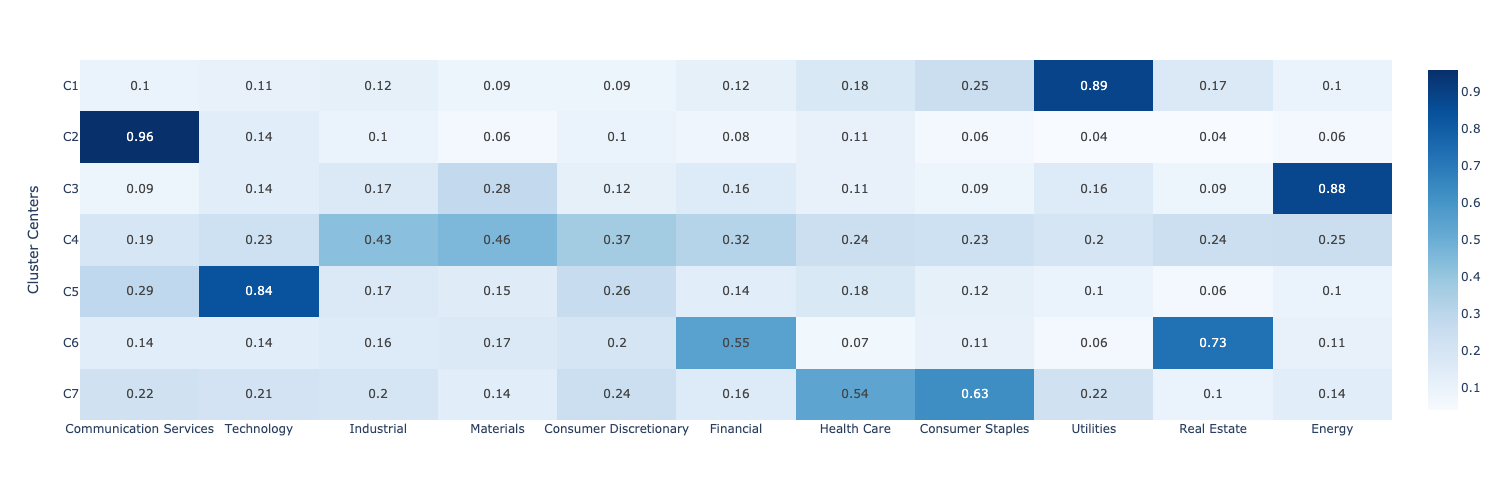

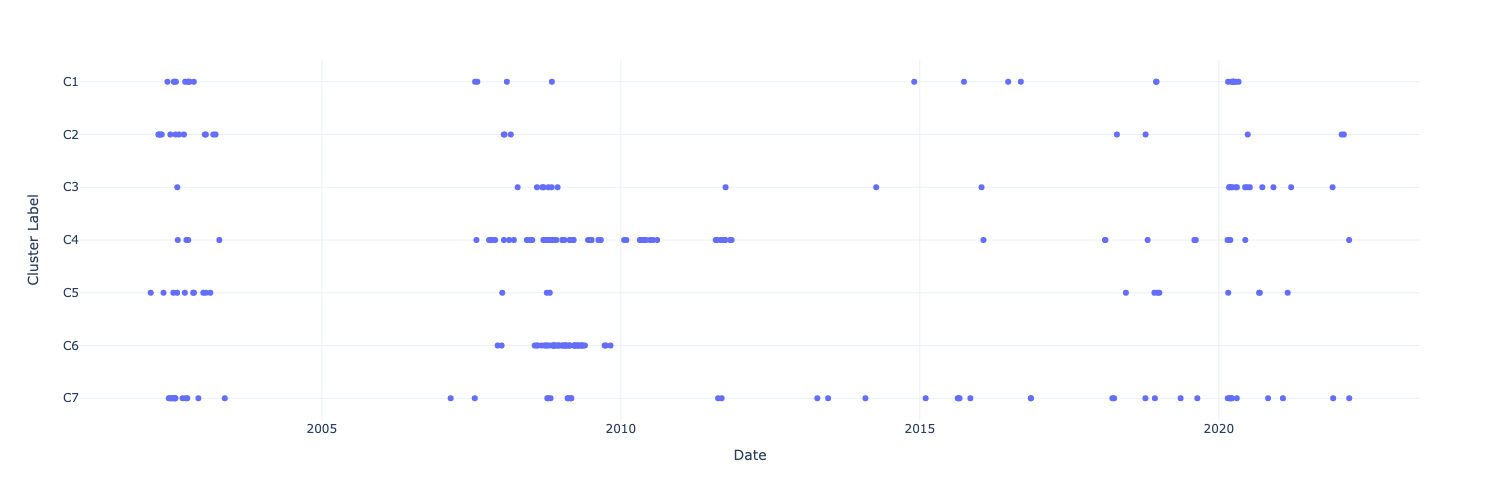

In [12]:
for k in range(2,8):
    
    fig1, fig2 = R_kmeans(k)
    
    if k>3:
        fig1.write_image('../figures/skmeans_centers_'+str(k)+'.jpeg', scale=2)
        
    if k==7:
        fig2.write_image('../figures/skmeans_labels_'+str(k)+'.jpeg', scale=2)
    
    fig1.show()
    fig2.show()

## Without Market - n_clusters=7

In [13]:
k = 7

centers = pd.read_csv('../data/skmeans'+str(k)+'_centers.csv').iloc[:,1:]
centers.columns = ll.columns[1:]
centers.index = ['C'+str(i) for i in range(1,k+1)]

labels = pd.read_csv('../data/skmeans'+str(k)+'_labels.csv').iloc[:,1]
labels.index = w[r>r0].index
labels = labels.apply(lambda x: 'C'+str(x))

sp500 = pd.read_csv('../data/data1.csv').iloc[:,:2]
sp500 = sp500.set_index('Date')

label_colors = pd.Series('C0', index=sp500.index)
label_colors.loc[w[r>r0].index] = labels.values

# Color Map
cmap = {
    'C5': "#636EFA", #blue
    'C4': "#EF553B", #red
    'C7': "#00CC96", #green
    'C1': "#AB63FA", #purple
    'C3': "#FECB52", #yellow
    'C2': "#19D3F3", #lightblue
    'C6': "grey"
}

In [14]:
#go.Figure(go.Scatter(x=sp500.index, y=sp500.iloc[:,0], line_color=cmap['C6']))

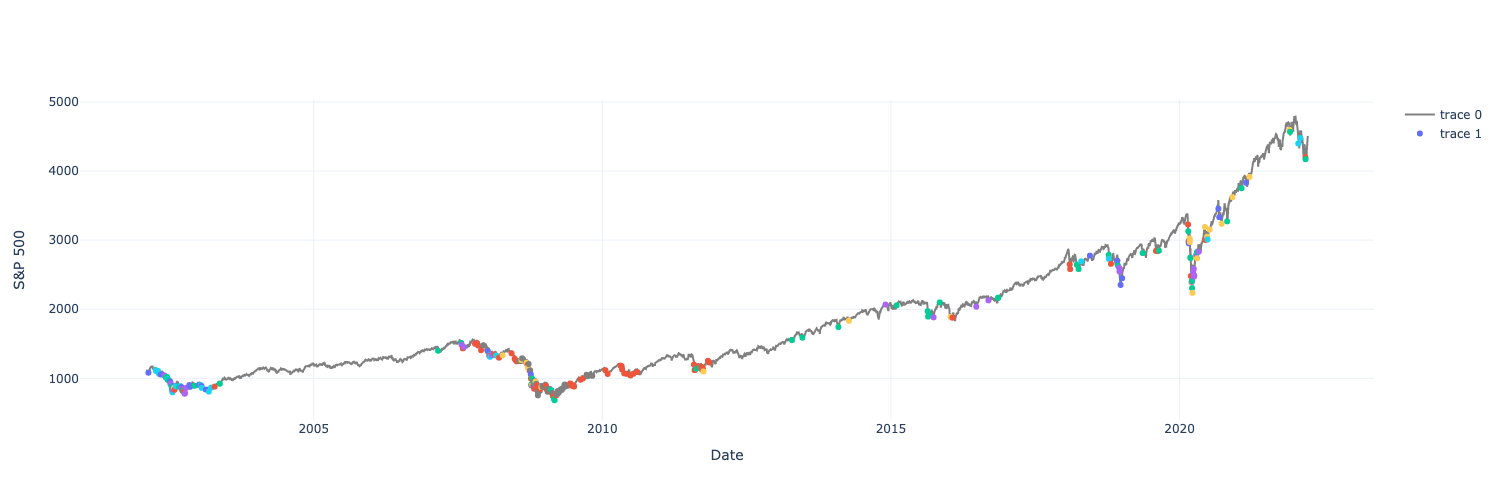

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=sp500.index, y=sp500['S&P Market'], line_color='grey'))
fig.add_trace(go.Scatter(
    x=w[r>r0].index, y=sp500.loc[w[r>r0].index,'S&P Market'], marker_color=[cmap[x] for x in labels],
    mode = 'markers'
))

fig.update_layout(
    xaxis_title='Date', yaxis_title='S&P 500', height=500, width=1500
)

#fig.update_yaxes(categoryorder='array', categoryarray=['C'+str(i) for i in range(7)])

fig.show()

## With Market - n_clusters=7

In [16]:
centers = pd.read_csv('../data/skmeans7_centers_market.csv').iloc[:,1:]
centers.columns = ll.columns
centers.index = ['C'+str(i) for i in range(1,k+1)]

labels = pd.read_csv('../data/skmeans7_labels_market.csv').iloc[:,1]
labels.index = w[r>r0].index
labels = labels.apply(lambda x: 'C'+str(x))

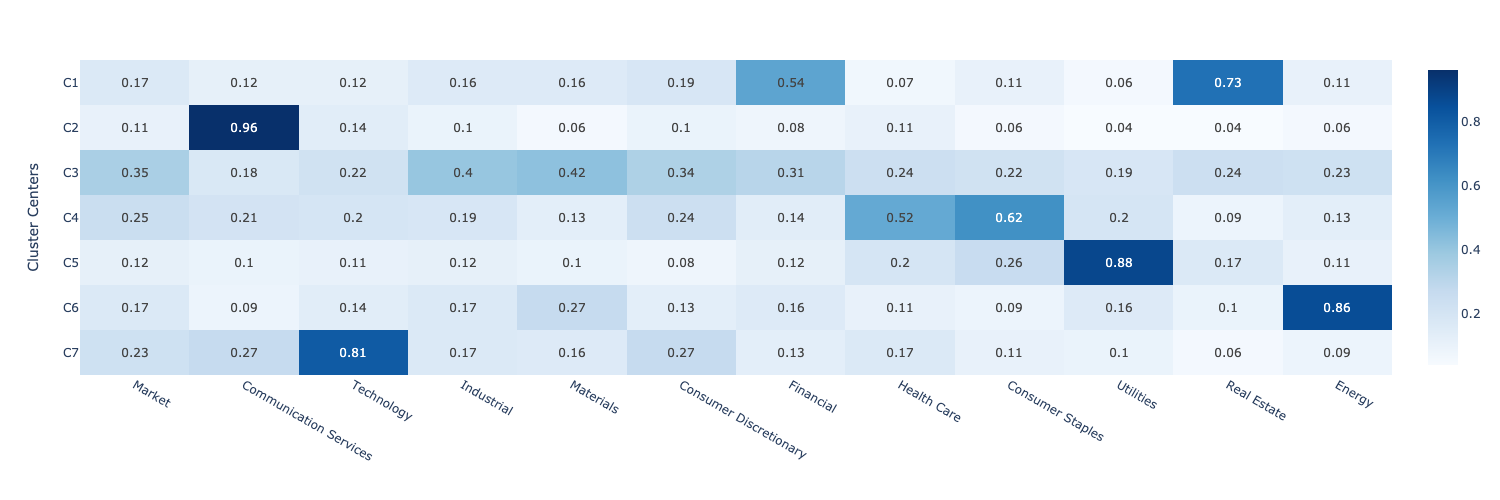

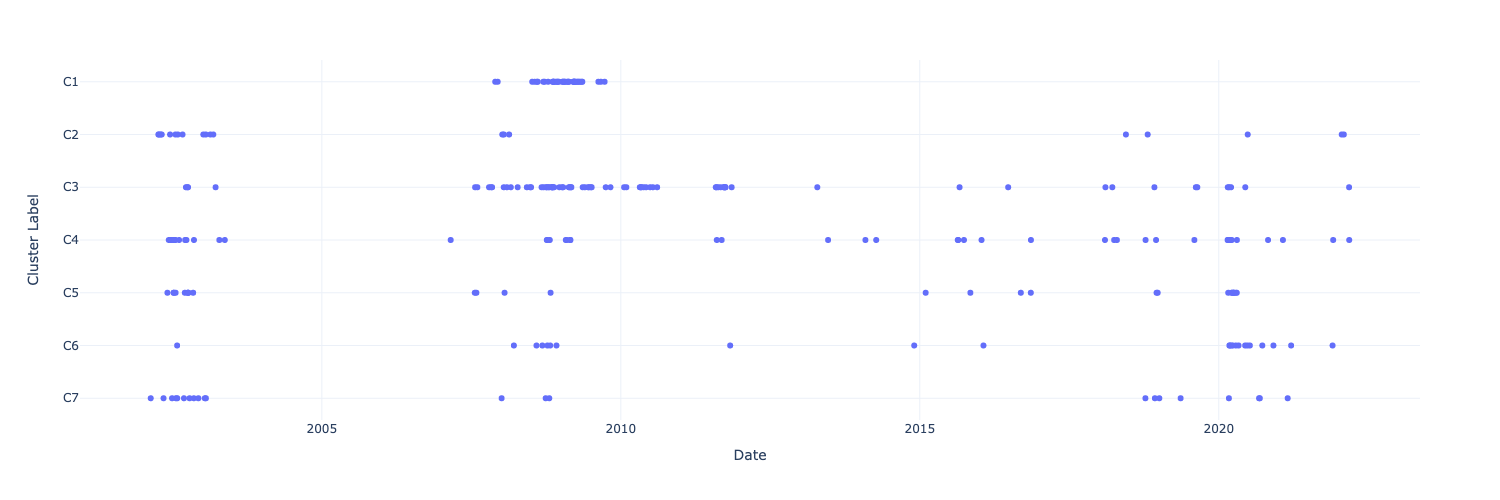

In [17]:
fig1, fig2 = plot_kmeans(centers,labels)

fig1.show()
fig1.write_image('../figures/skmeans_centers_7_market.jpeg', scale=2)

fig2.show()